1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


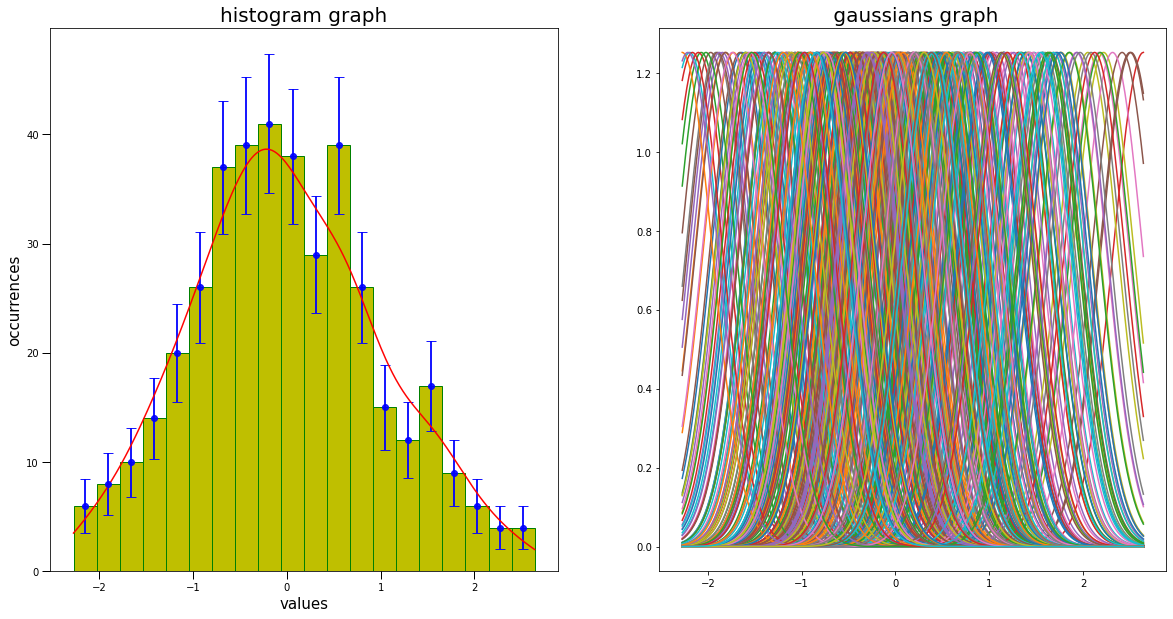

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy import stats
%matplotlib inline


# NUMBER ( 1 ) : Draw random samples from a normal (Gaussian) distribution.

#Fill a numpy array 
N=400
X=np.random.normal(loc=0.0, scale=1.0, size=N)

#Fill an histogram in pyplot 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

histogram,bins,_=ax1.hist(X, color = 'y', edgecolor = 'g',bins =int(np.sqrt(N)))
ax1.set_xlabel('values',size=15)
ax1.set_ylabel('occurrences',size=15)
ax1.set_title('histogram graph', size=20)

#set proper value of y axis major ticks labels
ax1.tick_params(which='major', width=1.0, length=8, labelsize=10)
 
#display the histograms as data points with errors
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax1.errorbar(bin_centers, histogram, yerr=np.sqrt(histogram), fmt='bo' , alpha=0.9 ,color='b',elinewidth=2, capsize=5) 
  



sigma=1.06*X.std()*X.size**(-1/5)
gaussians=np.zeros((N,N))
xg=np.linspace(X.min(),X.max(),N)

for i in range(len(X)):
    gaussians[i] = stats.norm.pdf(xg, X[i], sigma)
    ax2.plot(xg,gaussians[i])
    ax2.set_title(' gaussians graph',size=20)
    

#Sum (with np.sum()) all the gaussian functions and normalize the result ,use the scipy.integrate.trapz() method

density=np.sum(gaussians,axis=0)
integral_first=scipy.integrate.trapz(histogram,bin_centers)
integral_second = scipy.integrate.trapz(density, xg)
ax1.plot(xg, density*(integral_first/integral_second), alpha=5,color='red')
 

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 14:38:20--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-17 14:38:20--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucf08e6905d1af2d3896db082fc4.dl.dropboxusercontent.com/cd/0/inline/BDXix2_dqdgaay0CqpUasoeq-d7qojUHdcsmMO4LSt4qx-6aIfFdyTse5ykuTp1AKTZzWHqB83UcrULRU6e9PqpgyW2Ud6gq_BVV1oIDp8Jfng/file# [segue]
--2020-11-17 14:38:21--  https://ucf08e6905d1af2d3896db082fc4.dl.dropboxusercontent.com/cd/0/inline/BDXix2_dqdgaay0CqpUasoeq-d7qojUHdcsmMO4LSt4qx-6aIfFdyTse5ykuTp1AKTZzWHqB83Ucr

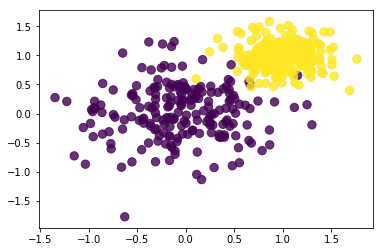

In [18]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

<ipython-input-20-f291c8b47afb>:15: RuntimeWarning: covariance is not positive-semidefinite.
  data2 =np.random.multivariate_normal(mean_second, cov_second, N)


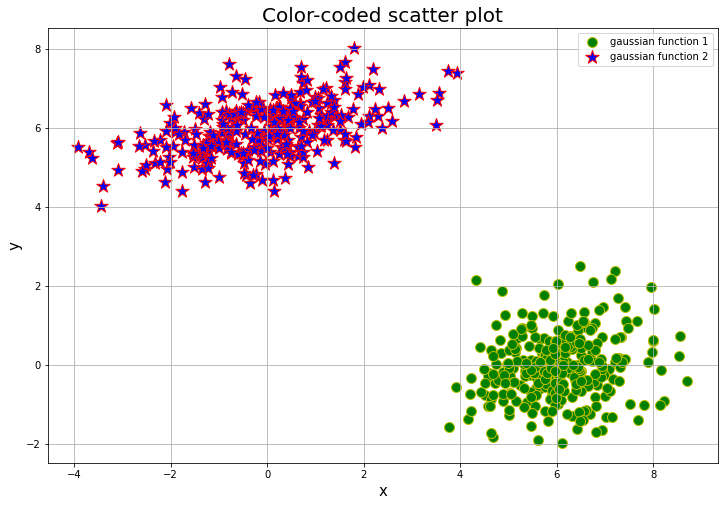

In [20]:
# A standard deviation (or σ or std) is a measure of how dispersed the data is in relation to the mean
# (µ or mean) : its exactly the central of gaussian function
# ( cov ) :covariance is a measure of the joint variability of two random variables

#Write a function that generate a 2D datasets of 2 categories

import random

def gauss_2d(N):
    mean_first = [6,0]
    mean_second=[0,6]
    cov_first = [[0.8, 0.1],[0.1, 0.7]]
    cov_second = [[1.6, 0.7],[1.2, 0.1]]
    data = np.random.multivariate_normal(mean_first, cov_first, N) 
    data2 =np.random.multivariate_normal(mean_second, cov_second, N)  
    return data,data2

data,data2=gauss_2d(300)

#Display the dataset in a scatter plot marking the two categories with different marker colors
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))  
plt.scatter (data[:,0], data[:,1], c='green',marker='o',edgecolor='y',s=100, label='gaussian function 1')    
plt.scatter (data2[:,0], data2[:,1], c='blue',marker='*',edgecolor='r',s=200, label='gaussian function 2')
plt.legend()
plt.title("Color-coded scatter plot",size=20)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
plt.grid()
plt.show()




3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [6]:
#load data as a pandas dataframe

import pandas as pd
load_file=np.load('residuals_261.npy',allow_pickle=True)
item_method=load_file.item()
data=pd.DataFrame(item_method)
data

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [7]:
#Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
new_data=data[abs(data["residuals"])<2]
new_data

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [8]:
#perform a linear regression of "residuals" versus "distances"

slope, intercept, r_value, p_value, std_err=scipy.stats.linregress(new_data['residuals'],new_data['distances'])
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: 0.577913    intercept: 10.025258
R-squared: 0.001884


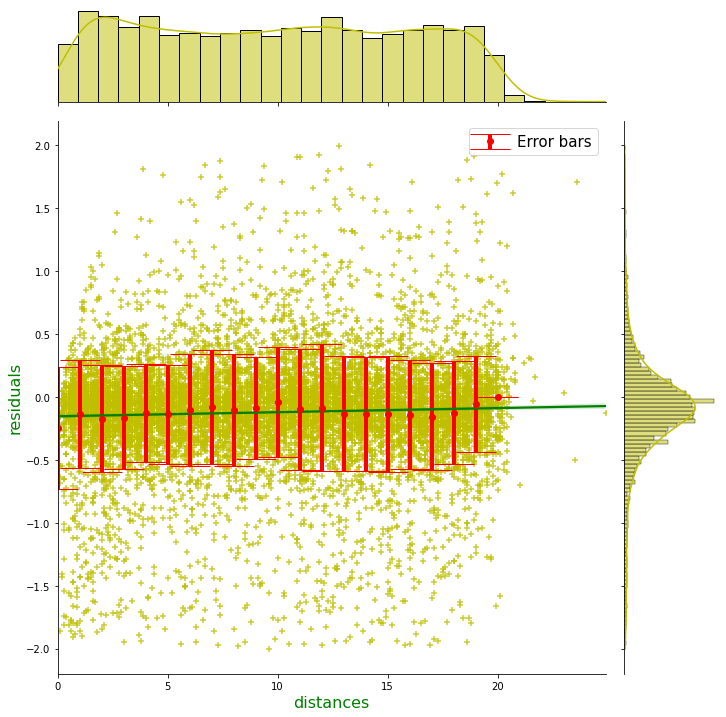

In [41]:
#plot a seaborn jointplot of "residuals" versus "distances"
import seaborn as sns
plot=sns.jointplot(x="distances", y="residuals", data=new_data, marker='+',height=10, kind="reg", line_kws={'color':'g'}, color='y')
plot.set_axis_labels("distances", "residuals", fontsize=16,color='g')

#Fill 3 numpy arrays

n_bins = 20
# x: serving as an array of bin centers for the "distance" variable
x = np.linspace(0,20, n_bins+1)
#y :the mean values of the "residuals", estimated in slices (bins) of "distance"
y = np.zeros(len(x))
#erry :the mean values of the "residuals", estimated in slices (bins) of "distance"
erry = np.zeros(len(x))
count = 0
for i in range(1, len(x)):
    d_tmp1 = new_data[new_data['distances'] < x[i]]
    d_tmp2 = d_tmp1[d_tmp1['distances'] >= x[i-1]]
    y[i-1] = d_tmp2['residuals'].mean()
    erry[i-1] = d_tmp2['residuals'].std()    
plt.errorbar(x, y, erry,label = 'Error bars',fmt = 'o', color='r',elinewidth=4, capsize=20)
plt.legend(loc = "best", fontsize = 15)
plt.show()